<a href="https://colab.research.google.com/github/parthnaik13/NYRA/blob/main/3_1_POC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC 1 for NYRA Analytics

https://www.kaggle.com/competitions/big-data-derby-2022/overview

This notebook aims to do some univariate exploration into the idea of assesing and quantifying the effects of load management on horse performance

In this notebook, we attempt to look at horse performance in the form of average race speed across the horse racing season

## Plan

* Load the NYRA complete data
* Join this data with this [dataset](https://www.kaggle.com/datasets/themarkgreen/big-data-derby-2022-global-horse-ids-and-places) to obtain unique horse ids, horse names and finish positions for horses in races
* Select races on "Dirt" tracks and track condition is "FT"
* Extract avg speeds for the horse races using code found in this [notebook](https://www.kaggle.com/code/roniheka/obtain-time-course-of-speed-during-a-race)
* Plot avg speeds for example horses across races from the start of the season to the end of the season
  * Do we see the plots having a -ve slope?
  * Do we see differences between the slopes of the plots across different horses?


## Setup

Load necessary libraries and datasets

Assign appropriate dtypes to columns

In [ ]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libs and print out their versions
import numpy as np
np.random.seed(7)

import pandas as pd
pd.set_option('display.max_columns', None) # Display all dataframe columns

import matplotlib
import matplotlib.pyplot as plt

print(f'numpy version - {np.__version__}')
print(f'pandas version - {pd.__version__}')
print(f'matplotlib version - {matplotlib.__version__}')

numpy version - 1.21.6
pandas version - 1.3.5
matplotlib version - 3.2.2


In [ ]:
# Load the NYRA complete dataset
nyra_complete_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/nyra_2019_complete.csv')
print(f'Shape of the df - {nyra_complete_df.shape}')
nyra_complete_df.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Shape of the df - (5228430, 17)


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090


In [ ]:
# Assign proper dtypes wherever needed
# race_date as datetime col
nyra_complete_df['race_date'] = pd.to_datetime(nyra_complete_df['race_date'])
# race_number as a int/numeric col
nyra_complete_df['race_number'] = pd.to_numeric(nyra_complete_df['race_number'])
# post_time as a datetime col
nyra_complete_df['post_time'] = pd.to_datetime(nyra_complete_df['post_time'], format= '%H%M')

In [ ]:
# Load horse_id data
# This is the additioal data found https://www.kaggle.com/datasets/themarkgreen/big-data-derby-2022-global-horse-ids-and-places?select=horse_ids.csv
# This data contains unique horse_ids for track_id, race_date, race_number, program_number mappings
# Also contains finish positions of horses
nyra_horse_id_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/horse_ids.csv', index_col = 0)
print(f'Shape of the df - {nyra_horse_id_df.shape}')
nyra_horse_id_df.head(5)

Shape of the df - (14916, 6)


,track_id,race_date,race,program_number,horse_id,finishing_place
0,AQU,2019-01-01,1,5,0,1
1,AQU,2019-01-01,1,1,1,2
2,AQU,2019-01-01,1,2,2,3
3,AQU,2019-01-01,1,3,3,4
4,AQU,2019-01-01,1,4,4,5


In [ ]:
# Check for nulls, since this is a new dataset
nyra_horse_id_df.isnull().sum()

track_id           0
race_date          0
race               0
program_number     0
horse_id           0
finishing_place    0
dtype: int64

In [ ]:
# Look at the dtypes, since this is a new dataset
nyra_horse_id_df.dtypes

track_id           object
race_date          object
race                int64
program_number     object
horse_id            int64
finishing_place     int64
dtype: object

In [ ]:
# Format dataframe
# Make the race col consistent with the race_number used in the Kaggle datasets
nyra_horse_id_df = nyra_horse_id_df.rename(columns={'race':'race_number'})
# race_date as a datetime
nyra_horse_id_df['race_date'] = pd.to_datetime(nyra_horse_id_df['race_date'])

In [ ]:
# Number of unique horse_ids in this dataset
# There are 4638 horses participating in these races as opposed to the 20 we get by grouping on the program number
len(nyra_horse_id_df['horse_id'].unique())

4638

count    4638.000000
mean        3.216041
std         2.706055
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        21.000000
Name: race_count, dtype: float64


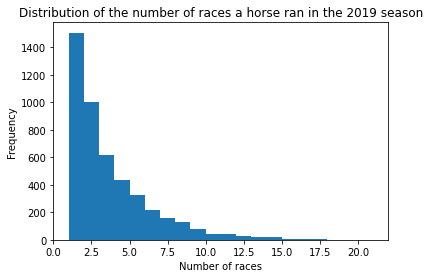

In [ ]:
# Look at the distribution of the # of races run by these horses
temp = nyra_horse_id_df.groupby(['horse_id']).size().reset_index()
temp = temp.rename(columns={0:'race_count'})
print(temp['race_count'].describe())
# Histogram of the # of races a horse participated in
plt.hist(temp['race_count'], bins = 20)
plt.xlabel('Number of races')
plt.ylabel('Frequency')
plt.title('Distribution of the number of races a horse ran in the 2019 season')
plt.show()

The above plot for the number of races a horse has in the 2019 season points to horses having pretty low number of races across the year, verify if this is true

`Today's racehorses run an average of seven races per year. The chart at the top of this post is from the Jockey club, the governing body of Thoroughbred racing. - Google`

Given the above, sounds about right

In [ ]:
# Load the horse_names dataset which would allow us to get the names for the race horses by horse id
